<a href="https://colab.research.google.com/github/alik604/Notebooks/blob/master/Time%20Series/stock_algo_trading_CCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the libraries
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# !pip yfinance
import yfinance as yf

# !pip install ta
from ta import * # like any other bad programemr would do... 
import ta 

In [2]:
share = 'spy'

dataset = yf.download(share, start="2008-11-11") #, start="2017-01-01"
dataset = dataset.drop(columns=['Adj Close','Volume'])
dataset['MA'] = dataset.Close.rolling(window=5).mean()
dataset.dropna(inplace=True)
dataset.head(20)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,MA
Date,,,,,
2008-11-17,86.379997,88.559998,85.160004,85.470001,87.770000
2008-11-18,85.150002,87.220001,82.910004,87.080002,87.232001
2008-11-19,85.910004,86.870003,80.919998,81.500000,86.368001
2008-11-20,80.129997,82.510002,75.050003,75.449997,83.224001
2008-11-21,77.459999,80.900002,74.339996,79.519997,81.803999
2008-11-24,81.919998,86.989998,80.360001,85.029999,81.715999
2008-11-25,87.300003,87.510002,83.820000,85.660004,81.431999
2008-11-26,84.300003,89.190002,84.239998,88.970001,82.925999
2008-11-28,88.629997,90.129997,88.480003,90.089996,85.853999


The brainless strategy


In [3]:
def noStrat():
  df2 = dataset.iloc[0::20] #[1::20] start at 1, every 20th (monthly)
  invPerMonth = 1000/20
  total =0
  shares=0 
  total_invested=invPerMonth

  for i, row in df2.iterrows():
      numShares = math.floor((invPerMonth)/row.Close.round(2))
      shares+=numShares
      invPerMonth -= (row.Close.round(2) * numShares)

      invPerMonth += 1000/20
      total_invested +=invPerMonth

  resultOfNoStrat = int(dataset.tail(1).Close*shares+invPerMonth)
  #print("invPerMonth: ",invPerMonth)
  #print("num of shares" , shares)
  #print("num of shares * last closing ",int(dataset.tail(1).Close*shares)) #dataset.tail, not df2.tail
  #print("total: ", (int(dataset.tail(1).Close*shares)+invPerMonth))
  print(f'Buy and hold would yeild {resultOfNoStrat:.2f}, with a total of {total_invested:.2f}')
  return resultOfNoStrat

resultOfNoStrat = noStrat()

Buy and hold would yeild 18731.00, with a total of 24439.21


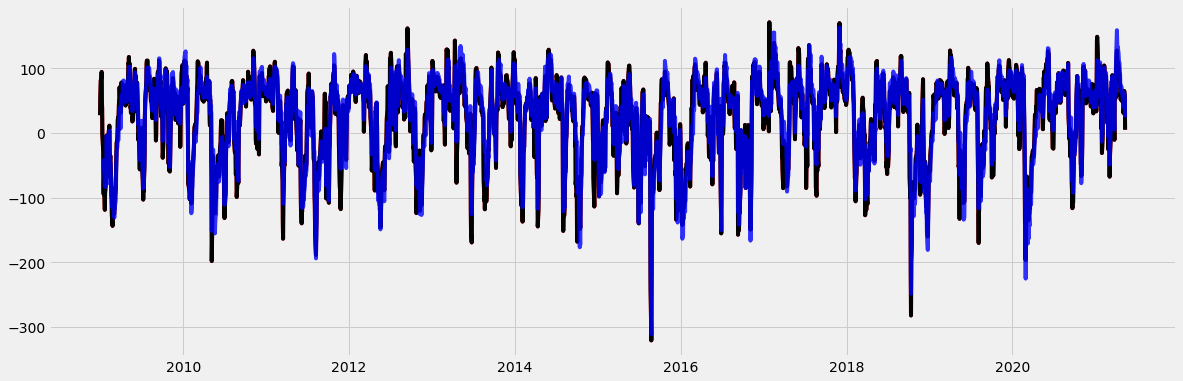

In [4]:
C =0.025#0.015
cci2 = ta.trend.cci(dataset.High,dataset.Low,dataset.Close, window=30, constant=C,fillna=False) # 'n' is now 'window'; 'c' is not 'constant'... damn API changes. current version on ta broke several notebooks. This is why I rerun past code every few years 
cci3 = ta.trend.cci(dataset.High,dataset.Low,dataset.Close, window=30, constant=C,fillna=False)
cci4 = ta.trend.cci(dataset.High,dataset.Low,dataset.Close, window=40, constant=C,fillna=False)

fig = plt.figure(figsize=(18,6))
plt.plot(cci2, color='r')
plt.plot(cci3, color='k', alpha = 1.0)
plt.plot(cci4, color='b', alpha = 0.8)
plt.show()

## the *light blue* is when the [b]lue does not cover the blac[k]

In [5]:
# plt.figure(figsize=(18,12))
# plt.plot(cci3)
# plt.show()

In [6]:
# plt.figure(figsize=(18,12))
# plt.plot(cci4)
# plt.show()

In [7]:
dataset["cci"] = cci3
dataset=dataset.dropna()
dataset.head(5)

,Open,High,Low,Close,MA,cci
Date,,,,,,
2008-12-30,87.510002,89.050003,86.879997,88.970001,87.172003,27.648132
2008-12-31,89.080002,90.970001,88.870003,90.239998,87.988002,53.735900
2009-01-02,90.440002,93.440002,89.849998,92.959999,89.248001,81.025677
2009-01-05,92.629997,93.660004,91.889999,92.849998,90.386000,86.091993
2009-01-06,93.639999,94.449997,92.680000,93.470001,91.698000,94.479892


## Plot days in which the CCI is > N

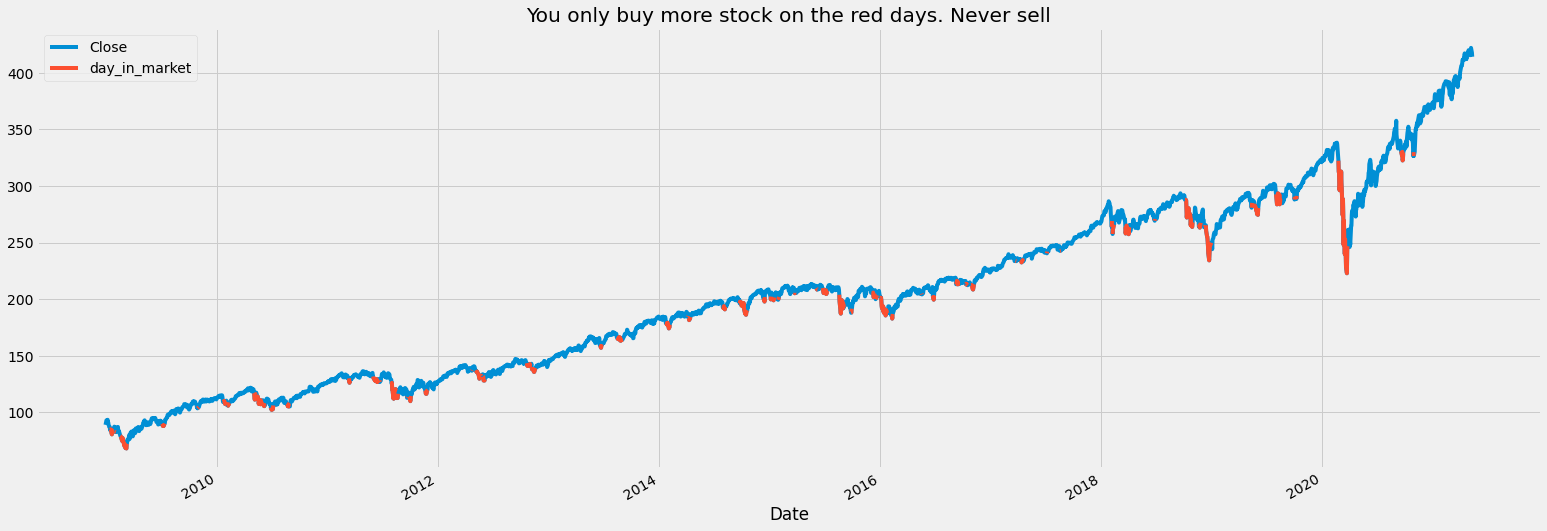

In [137]:
def plot_stock_cci_over_under(over=-100, under=100, dataset=dataset):
    tmp = dataset[(dataset['cci'] > over) & (dataset['cci'] < under)]
    a = set(dataset.index.values)
    b = set(tmp.index.values)
    idx_in_market = list(a-b)
    
    dataset['day_in_market'] = dataset.loc[idx_in_market].sort_index()['Close']
    dataset[['Close', 'day_in_market']].plot(figsize=(24, 9), title='You only buy more stock on the red days. Never sell')

plot_stock_cci_over_under(-50, 9999)

## Double for loop pram optimization

In [8]:
def CCIStrat(dataset=dataset):
  df2 = dataset.iloc[0::20] #[1::20] start at 1, every 20th (monthly)
  
  
  top_total=0
  top_min=0
  top_max=0
  
  
  cci_min = int(df2['cci'].min())-5
  
  cci_max = int(df2['cci'].max())+5
  for max in np.arange(cci_max)[::10]:
    #print(max)
    
  
    for min in np.arange(-cci_min)[::10]:
      min= -min
      #print(min)
      moneyToInvest = 1000/20
      total =0
      shares=0 
    
    
      for i in df2.index:
        Cci = df2.loc[i].at['cci']
        Close = df2.loc[i].at['Close']
        if(Cci > max):
          #sell
          #numShares = math.floor((moneyToInvest)/row.Close.round(2))
          moneyToInvest += (Close.round(2) * shares)
          shares=0


        if(Cci< min):
          #buy 
          numShares = math.floor((moneyToInvest)/Close.round(2))
          shares+=numShares
          moneyToInvest -= (Close.round(2) * numShares)

        moneyToInvest += 1000/20
        #end of innerloop 
      total = int(dataset.tail(1).Close*shares+moneyToInvest)
      if(total >top_total):
        top_total = total
        top_min   = min
        top_max   = max 
#       print("   min: {}\n   max: {}\n   total: {}".format(min,max,total))
  #print("moneyToInvest: ",moneyToInvest)
  #print("num of shares" , shares)
  #print("num of shares * last closing ",int(dataset.tail(1).Close*shares)) #dataset.tail, not df2.tail
  #print("total: ", (int(dataset.tail(1).Close*shares)+moneyToInvest))
  print("=======================================")
  print("   min: {}\n   max: {}\n   total: {}".format(top_min,top_max,top_total))
  print(f"   resultOfNoStrat: {resultOfNoStrat:.2f}")
#   return int(dataset.tail(1).Close*shares+moneyToInvest)

resultOfCCStrat = CCIStrat()

   min: 0
   max: 90
   total: 26318
   resultOfNoStrat: 18731.00


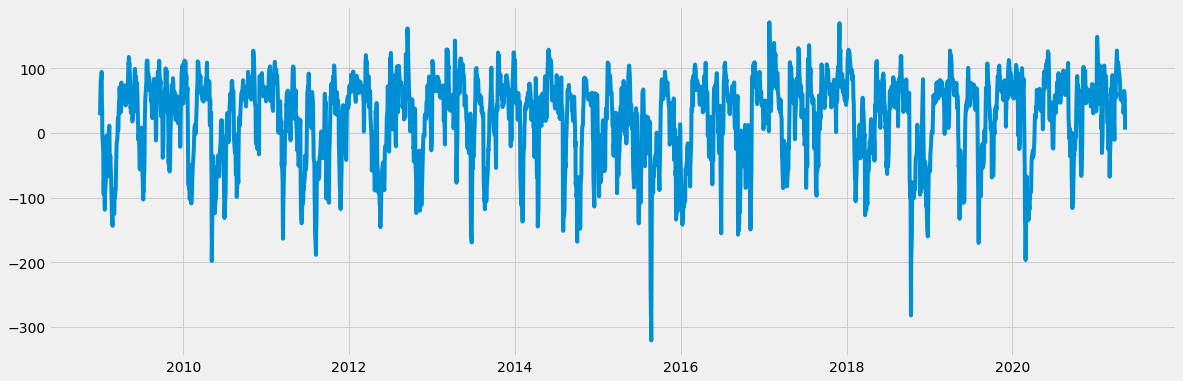

In [9]:
fig=plt.figure(figsize=(18,6))
plt.plot(dataset.cci)
plt.show()

In [140]:
upper = 110
lowwer = -60
allow_sell = True

def test(upper = 100, lowwer = -100, allow_sell=True):
    moneyToInvest = 1000/20
    total=0
    shares=0 
    df2 = dataset.iloc[0::20]
    for i in df2.index:
      Cci   = df2.loc[i].at['cci']
      Close = df2.loc[i].at['Close']

      if(Cci > upper and allow_sell):
        #sell
        moneyToInvest += (Close.round(2) * shares)
        shares=0

      if(Cci < lowwer):
        #buy 
        numShares = math.floor((moneyToInvest)/Close.round(2))
        shares+=numShares
        moneyToInvest -= (Close.round(2) * numShares)

      moneyToInvest += 1000/20
      total = int(dataset.tail(1).Close*shares+moneyToInvest)
        
    if allow_sell==False:
        print(f'     [Where selling is not permitted]')
        print("CCI to buy {}\nTotal money made: {}".format(lowwer, total))
    else:
        print("CCI to buy {}\nCCI to sell {}\nTotal money made: {}".format(lowwer, upper, total))
    print(f"What if we did buy and hold?: {resultOfNoStrat:.2f}")

    print(f"")

test()
test(upper = 110, lowwer = -60)
test(upper = 90, lowwer = -30)
test(upper = 90, lowwer = 0)

test(upper = 90, lowwer = -30, allow_sell=False)
test(upper = 90, lowwer = -70, allow_sell=False)

CCI to buy -100
CCI to sell 100
Total money made: 15695
What if we did buy and hold?: 18731.00

CCI to buy -60
CCI to sell 110
Total money made: 20482
What if we did buy and hold?: 18731.00

CCI to buy -30
CCI to sell 90
Total money made: 23678
What if we did buy and hold?: 18731.00

CCI to buy 0
CCI to sell 90
Total money made: 26318
What if we did buy and hold?: 18731.00

     [Where selling is not permitted]
CCI to buy -30
Total money made: 18357
What if we did buy and hold?: 18731.00

     [Where selling is not permitted]
CCI to buy -70
Total money made: 17118
What if we did buy and hold?: 18731.00



(3112, 7)


<AxesSubplot:title={'center':'Days you do not buy stock, as you don\'t want to "Buy high"'}, xlabel='Date'>

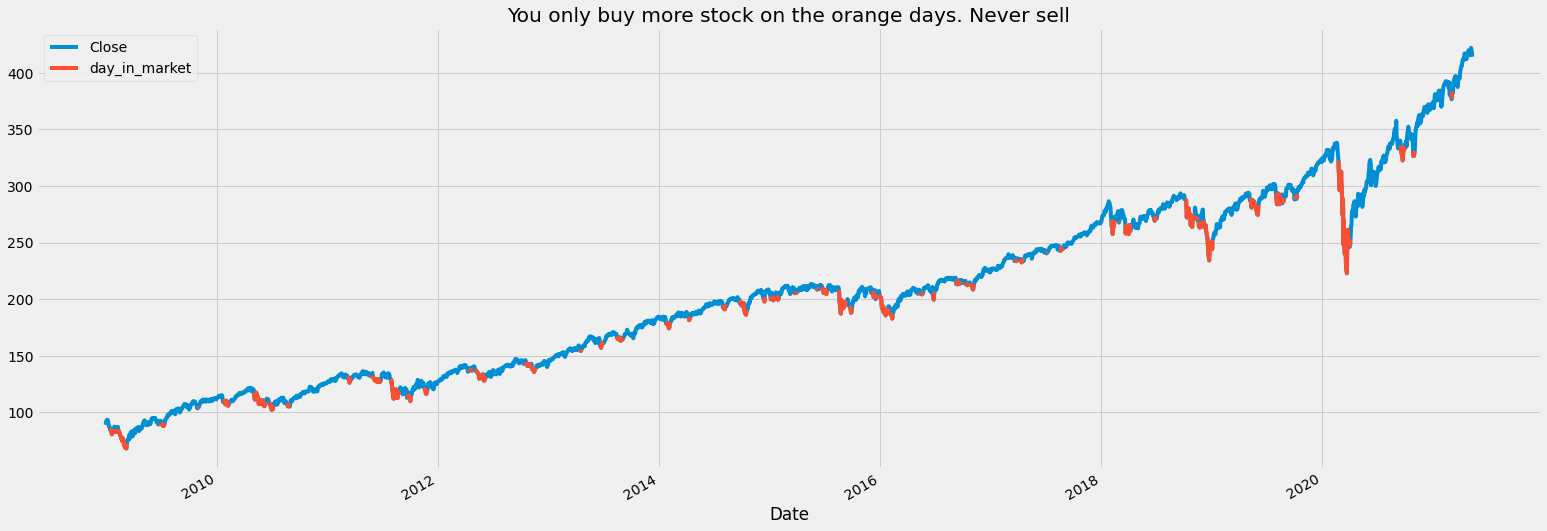

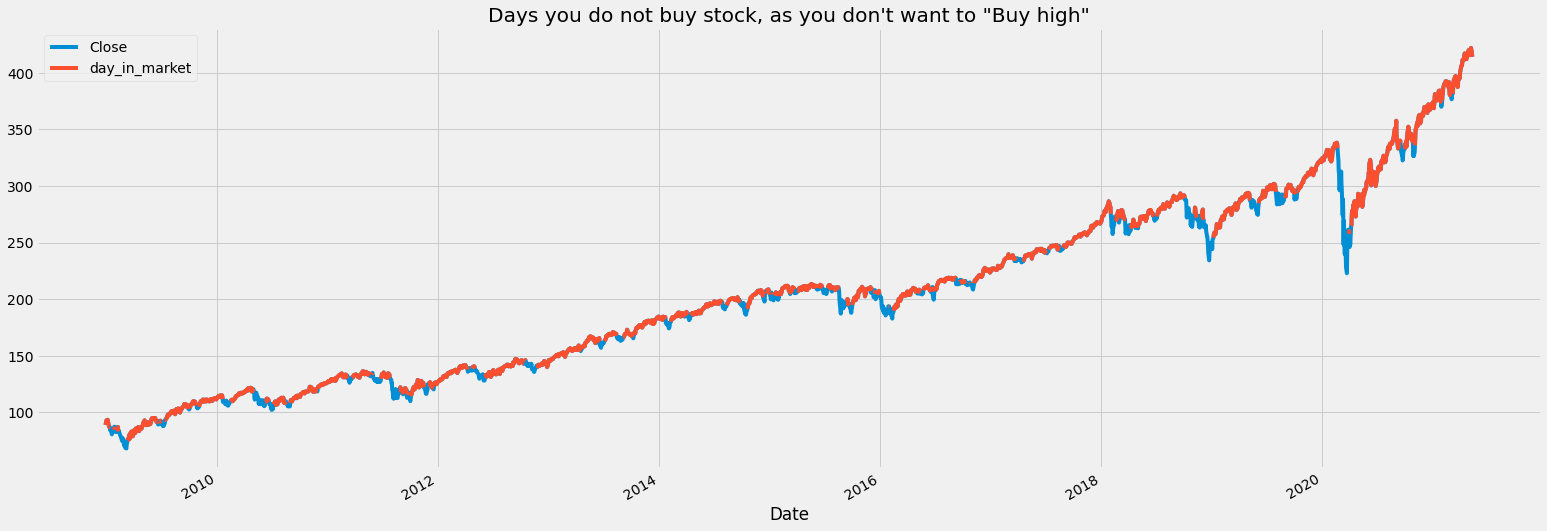

In [141]:
CCI_to_buy_below = -30
print(dataset.shape)

tmp = dataset[dataset['cci'] > CCI_to_buy_below]

a = set(dataset.index.values)
b = set(tmp.index.values)
idx_in_market = list(a-b)
dataset['day_in_market'] = dataset.loc[idx_in_market].sort_index()['Close']
dataset[['Close', 'day_in_market']].plot(figsize=(24, 9), title='You only buy more stock on the orange days. Never sell')


tmp = dataset[dataset['cci'] < CCI_to_buy_below]

a = set(dataset.index.values)
b = set(tmp.index.values)
idx_in_market = list(a-b)
dataset['day_in_market'] = dataset.loc[idx_in_market].sort_index()['Close']
dataset[['Close', 'day_in_market']].plot(figsize=(24, 9), title='Days you do not buy stock, as you don\'t want to \"Buy high\"')